# T-S diagrams from TAO & Argo

looking at TS diagrams across latitudes. 

1. During TIW activity do we see more stirring near the equator or off the equator?
2. If salinity is a minor contributor to density, do we really expect to see T-S scatter as a signal of eddy stirring?

In [1]:
%load_ext watermark

import cf_xarray
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xgcm

import eddydiff as ed
import pump

xr.set_options(keep_attrs=True)

%watermark -iv
plt.rcParams["figure.dpi"] = 180
plt.rcParams["savefig.dpi"] = 200

plt.style.use("bmh")
client = distributed.Client(n_workers=3)
client

cf_xarray  : 0.4.1.dev21+gab9dc66
dcpy       : 0.1
matplotlib : 3.4.1
numpy      : 1.20.2
pandas     : 1.2.3
pump       : 0.1
eddydiff   : 0.1
xgcm       : 0.5.1
xarray     : 0.17.1.dev3+g48378c4b1
distributed: 2021.3.1



/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33413 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44931' processes=3 threads=9, memory=33.39 GB>

## Argo

### Read data

In [11]:
ds = xr.open_mfdataset(
    "argo_140_20*_*.nc",
    preprocess=lambda ds: ds.drop_vars("N_POINTS"),
    concat_dim="N_POINTS",
    combine="nested",
).load()
ds.coords["year"] = ds.TIME.dt.year
ds

<xarray.Dataset>
Dimensions:                (N_POINTS: 1327818)
Coordinates:
    LATITUDE               (N_POINTS) float64 6.221 6.221 ... -1.509 -1.509
    LONGITUDE              (N_POINTS) float64 -140.0 -140.0 ... -138.7 -138.7
    TIME                   (N_POINTS) datetime64[ns] 2005-03-08T17:40:05 ... ...
Dimensions without coordinates: N_POINTS
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_POINTS) int64 1 1 1 1 1 1 1 ... 84 84 84 84 84 84
    CYCLE_NUMBER           (N_POINTS) int64 1 1 1 1 1 1 1 ... 84 84 84 84 84 84
    DATA_MODE              (N_POINTS) object 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    DIRECTION              (N_POINTS) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_POINTS) int64 5900884 5900884 ... 1902197 1902197
    POSITION_QC            (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_POINTS) float64 34.85 34.85 34.85 ... 34.62 34.62
    PSAL_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_POINTS) float64 27.97 27.97 27.97 ... 7.57 7.555
    TEMP_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           deepak
    Fetched_date:         2021/04/08
    Fetched_constraints:  [x=-145.00/-135.00; y=-2.00/8.00; z=0.0/500.0; t=20...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

## Latitudinal variation at 140W

Text(0.5, 1.0, '2005-2015')

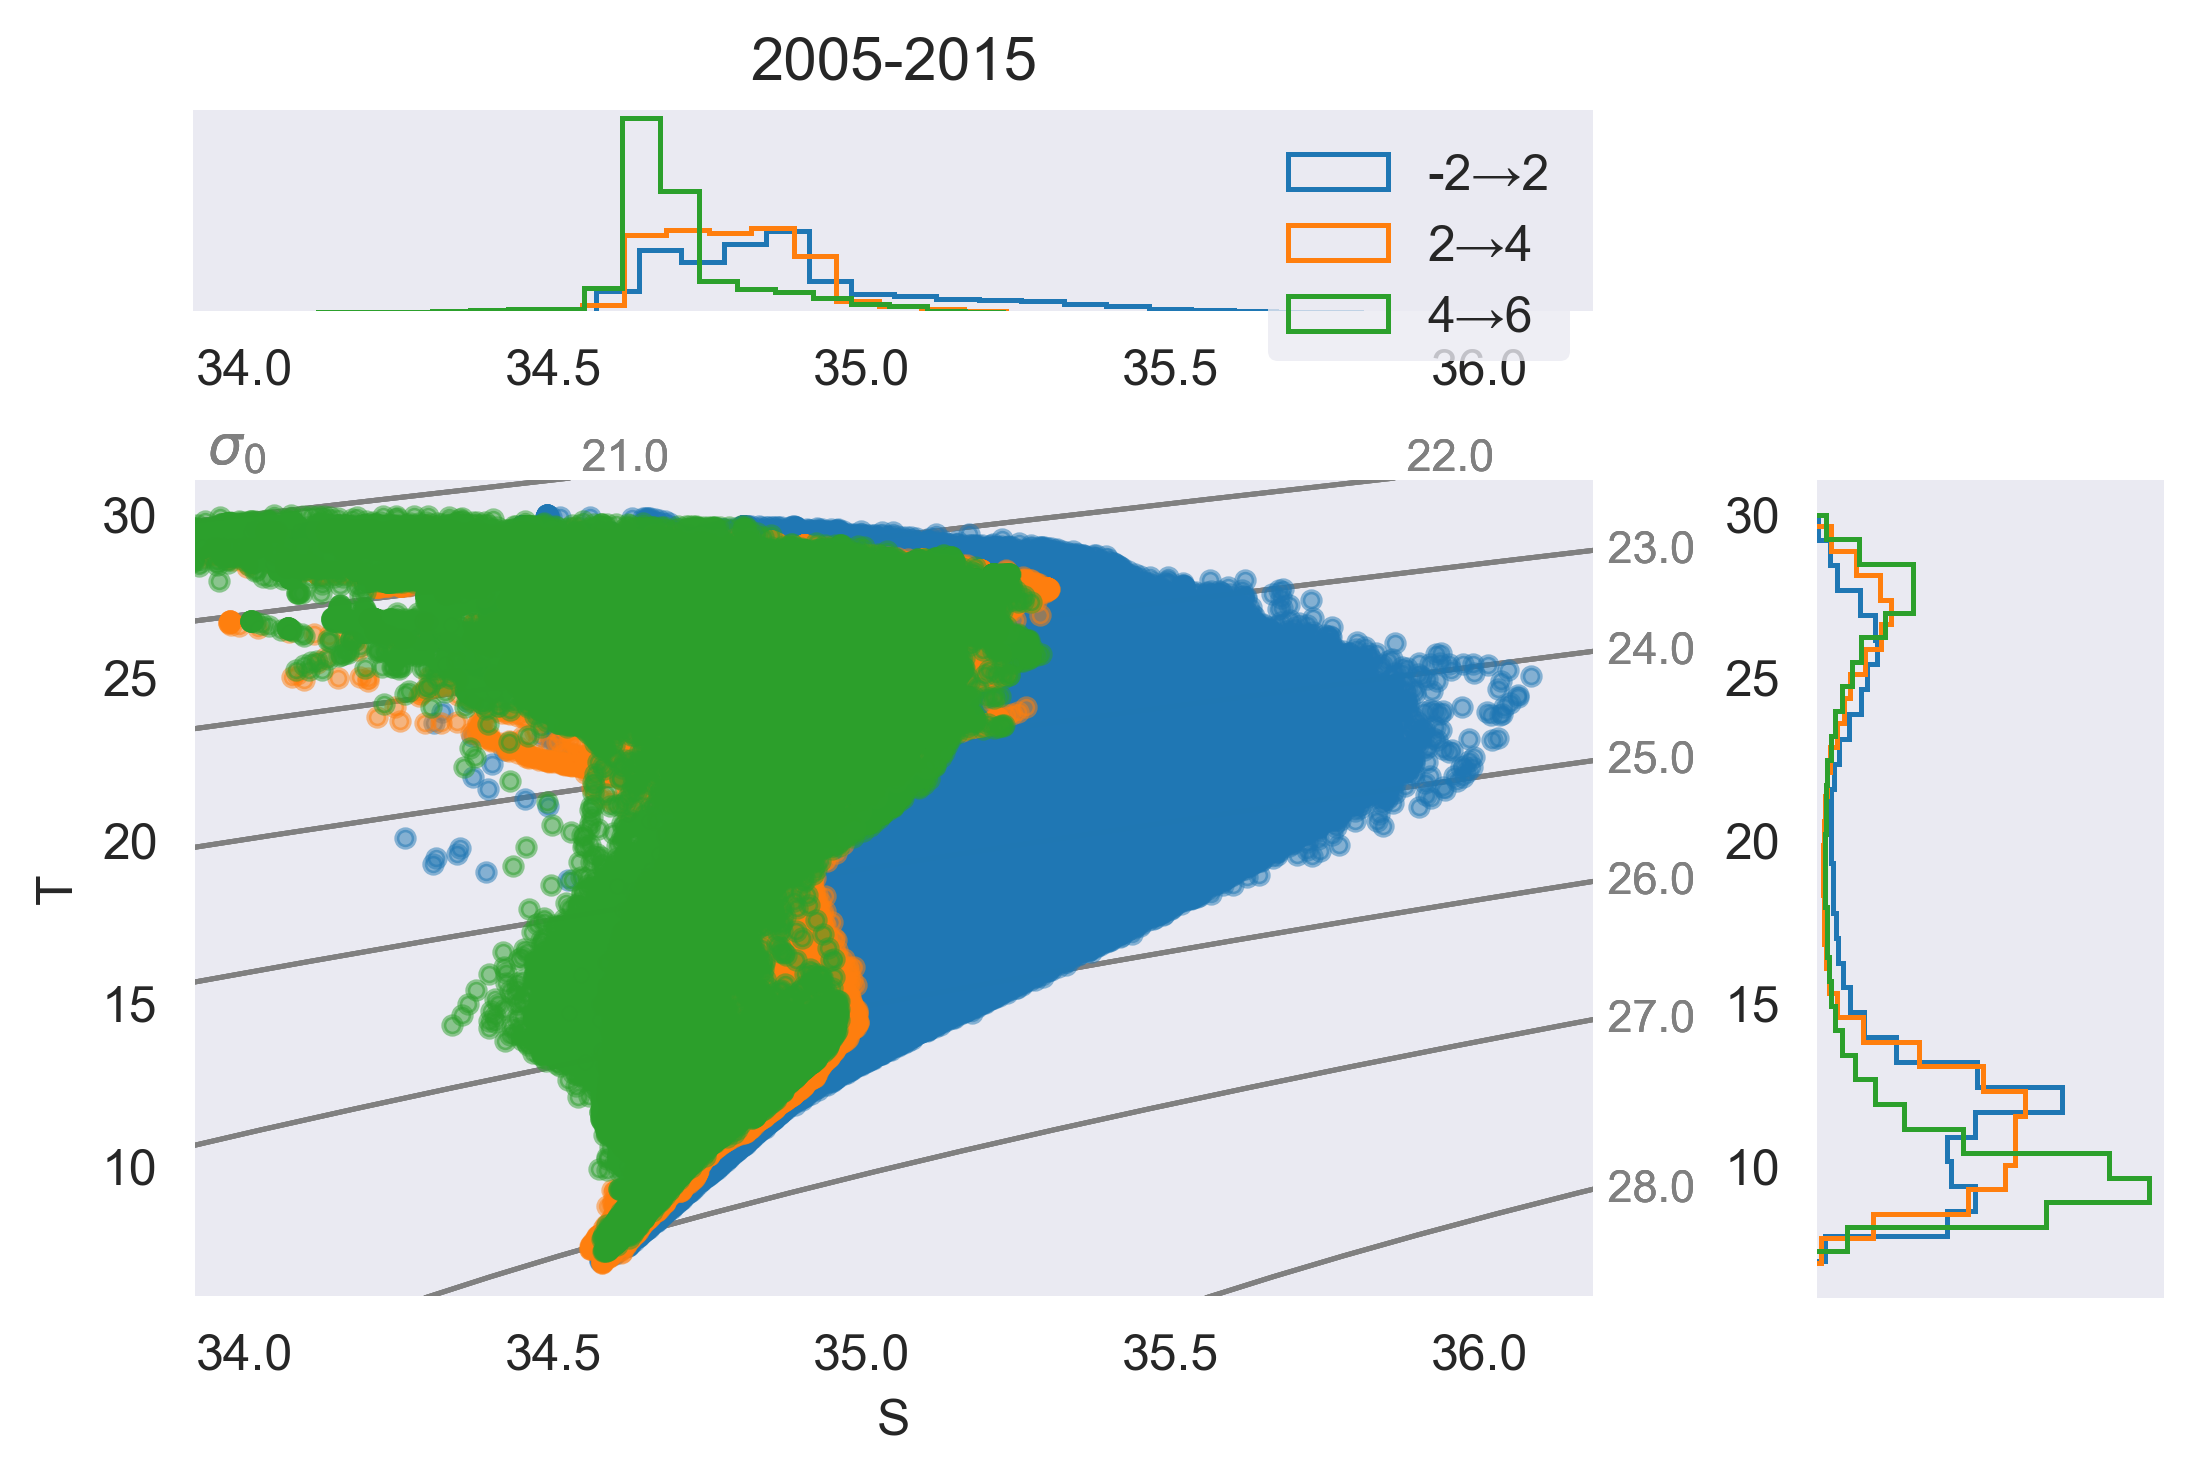

In [13]:
subset = ds.query({"N_POINTS": "LATITUDE > -2 & LATITUDE < 2"})
_, ax = dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False)

subset = ds.query({"N_POINTS": "LATITUDE > 2 & LATITUDE < 4"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False, ax=ax)

subset = ds.query({"N_POINTS": "LATITUDE > 4 & LATITUDE < 6"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False, ax=ax)

ax["s"].legend(["-2→2", "2→4", "4→6"])
ax["s"].set_title("2005-2015")

## Interannual variation at (2S→2N, -140)

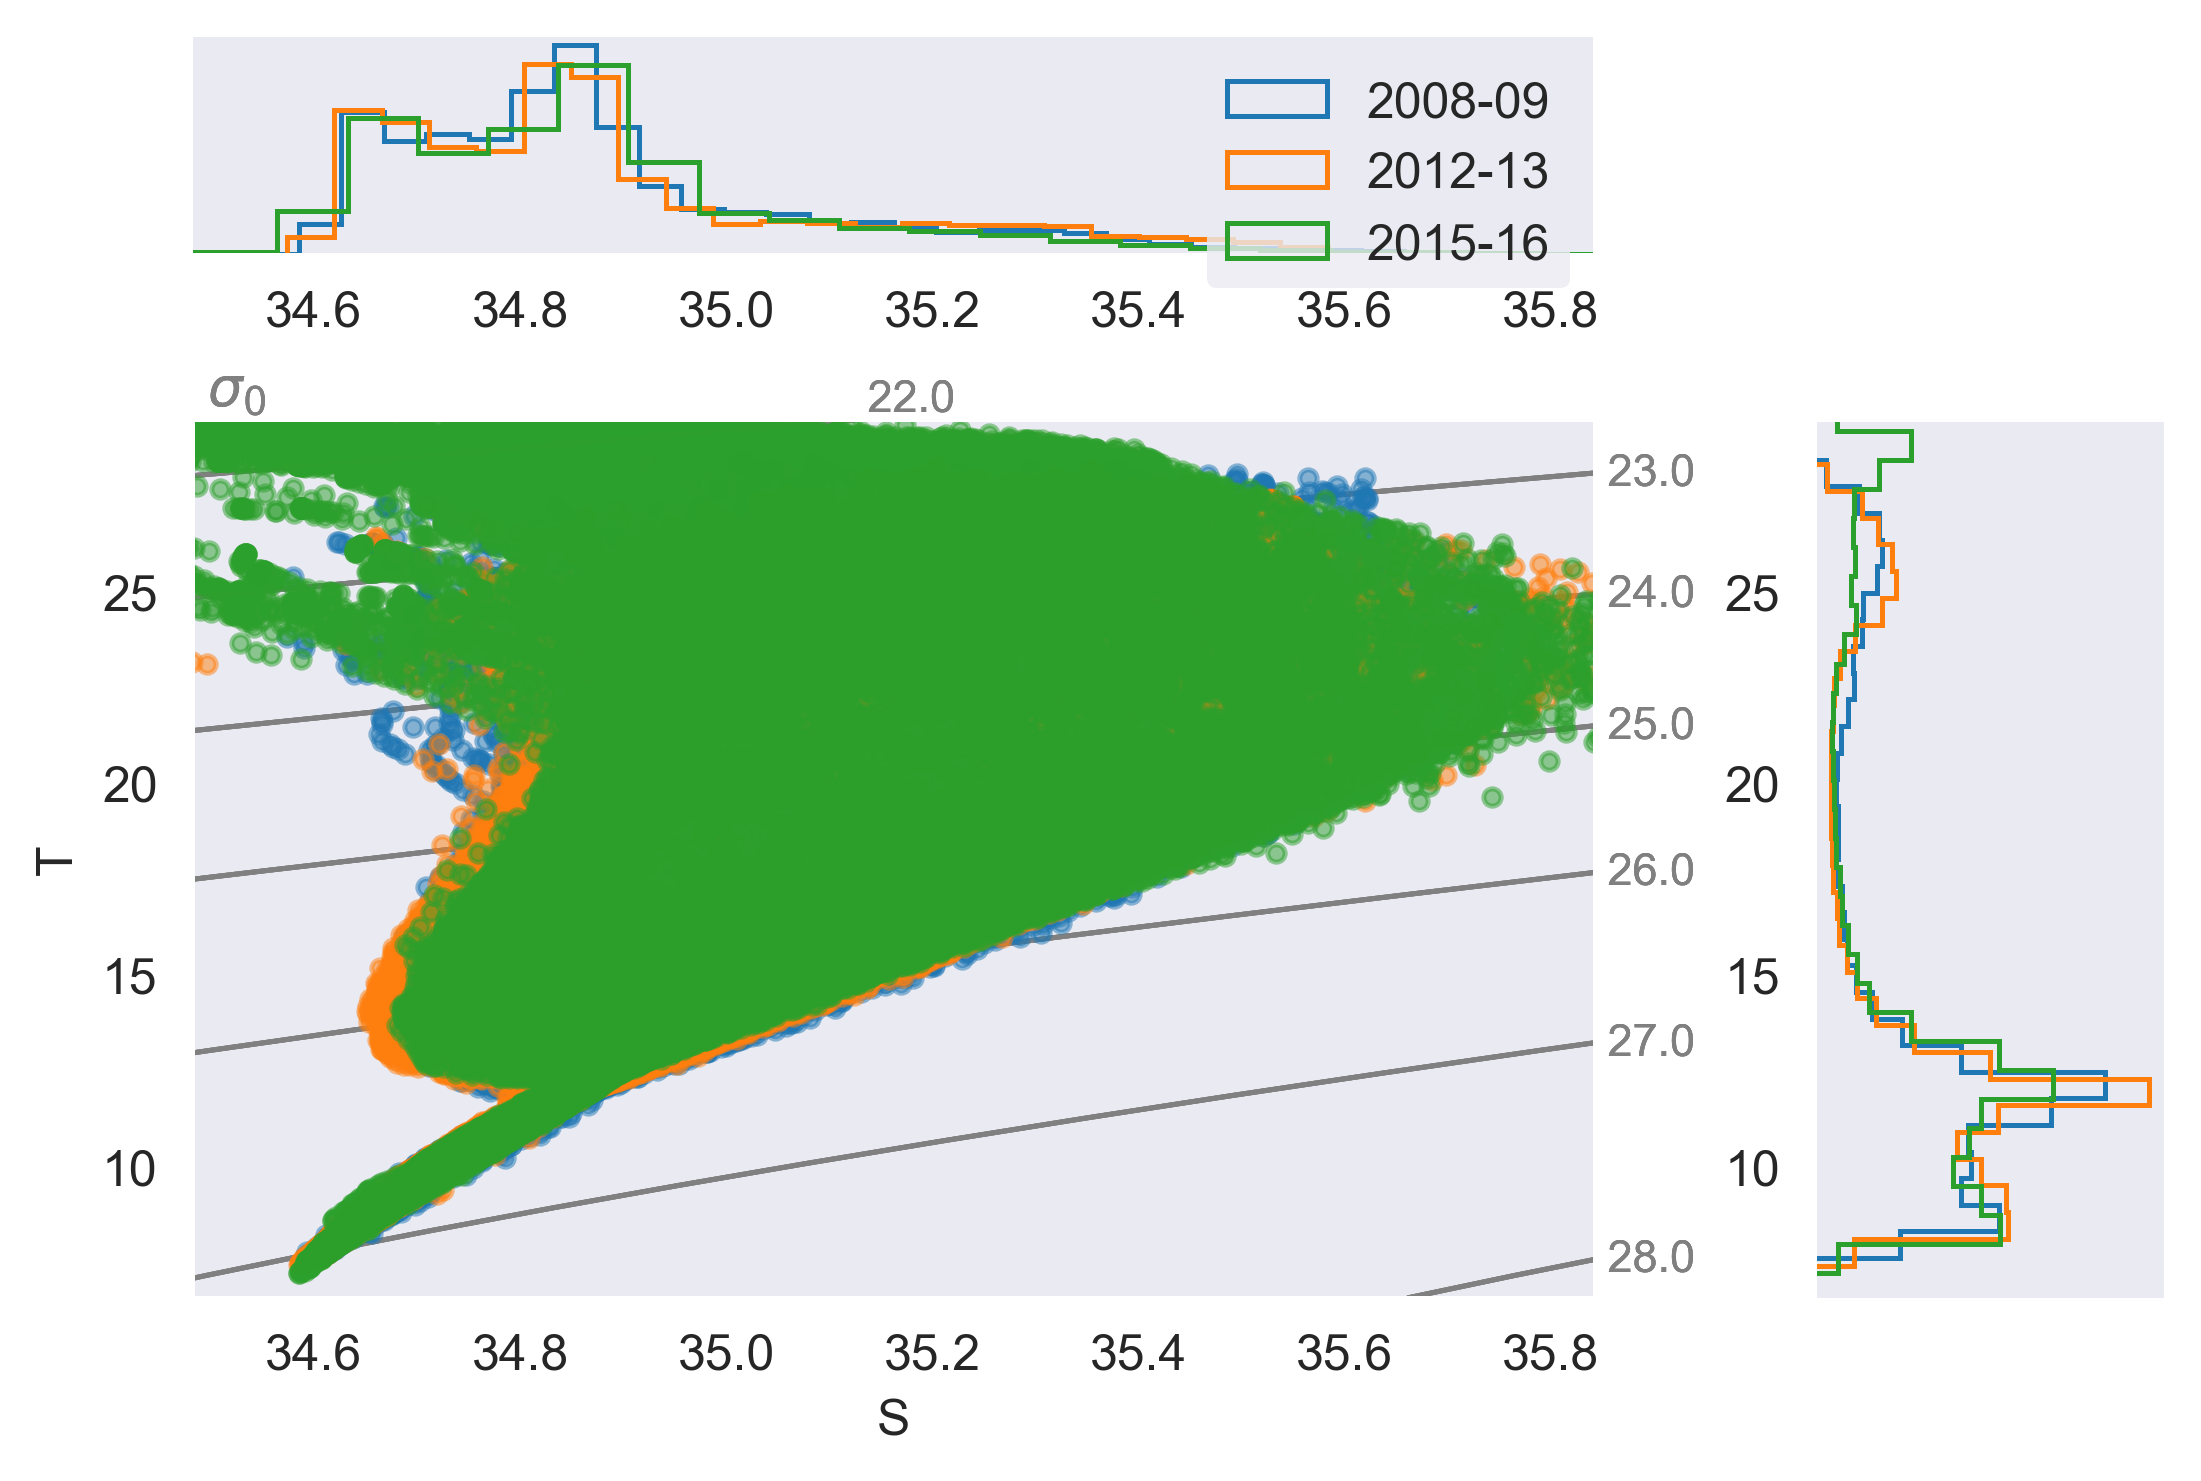

In [14]:
subset = ds.query({"N_POINTS": "LATITUDE > -2 & LATITUDE < 2 & (year == 2008 | year == 2009)"})
_, ax = dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False)

subset = ds.query({"N_POINTS": "LATITUDE > -2 & LATITUDE < 2 & (year == 2012 | year == 2013)"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False, ax=ax)

subset = ds.query({"N_POINTS": "LATITUDE > -2 & LATITUDE < 2 & (year == 2015 | year == 2016)"})
dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, hexbin=False, ax=ax)

ax["s"].legend(["2008-09", "2012-13", "2015-16"])

### ENSO variation of T-S diagram

In [183]:
from xarray.core.missing import _get_nan_block_lengths, get_clean_interp_index
nino34 = pump.obs.process_nino34()
ssta = nino34 - nino34.mean()
enso = xr.full_like(ssta, fill_value="Neutral", dtype="U8")
index = ssta.indexes["time"] - ssta.indexes["time"][0]
en_mask = _get_nan_block_lengths(xr.where(ssta > 0.5, np.nan, 0), dim="time", index=index) >= pd.Timedelta("179d")
ln_mask = _get_nan_block_lengths(xr.where(ssta < -0.5, np.nan, 0), dim="time", index=index) >= pd.Timedelta("179d")
enso.loc[en_mask] = "El-Nino"
enso.loc[ln_mask] = "La-Nina"
enso.name = "enso_phase"
enso.attrs["description"] = "ENSO phase; El-Nino = NINO34 SSTA > 0.5 for at least 6 months; La-Nina = NINO34 SSTA < -0.5 for at least 6 months"
enso

<xarray.DataArray 'enso_phase' (time: 864)>
array(['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'Neutral',
       'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'La-Nina', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'Neutral', 'Neutral', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino',
       'El-Nino', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'La-Nina', 'La-Nina', 'Neutral', 'Neutral', 'Neutral',
       'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'La-Nina', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'Neutral', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino',
       'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino',
...
       'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'La-Nina', 'La-Nina', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'La-Nina', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino',
       'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino',
       'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino', 'El-Nino',
       'Neutral', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'La-Nina', 'La-Nina', 'La-Nina', 'La-Nina',
       'La-Nina', 'La-Nina', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral'],
      dtype='<U8')
Coordinates:
  * time     (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2019-12-31
Attributes:
    description:  ENSO phase; El-Nino = NINO34 SSTA > 0.5 for at least 6 mont...

check ENSO phase calculation

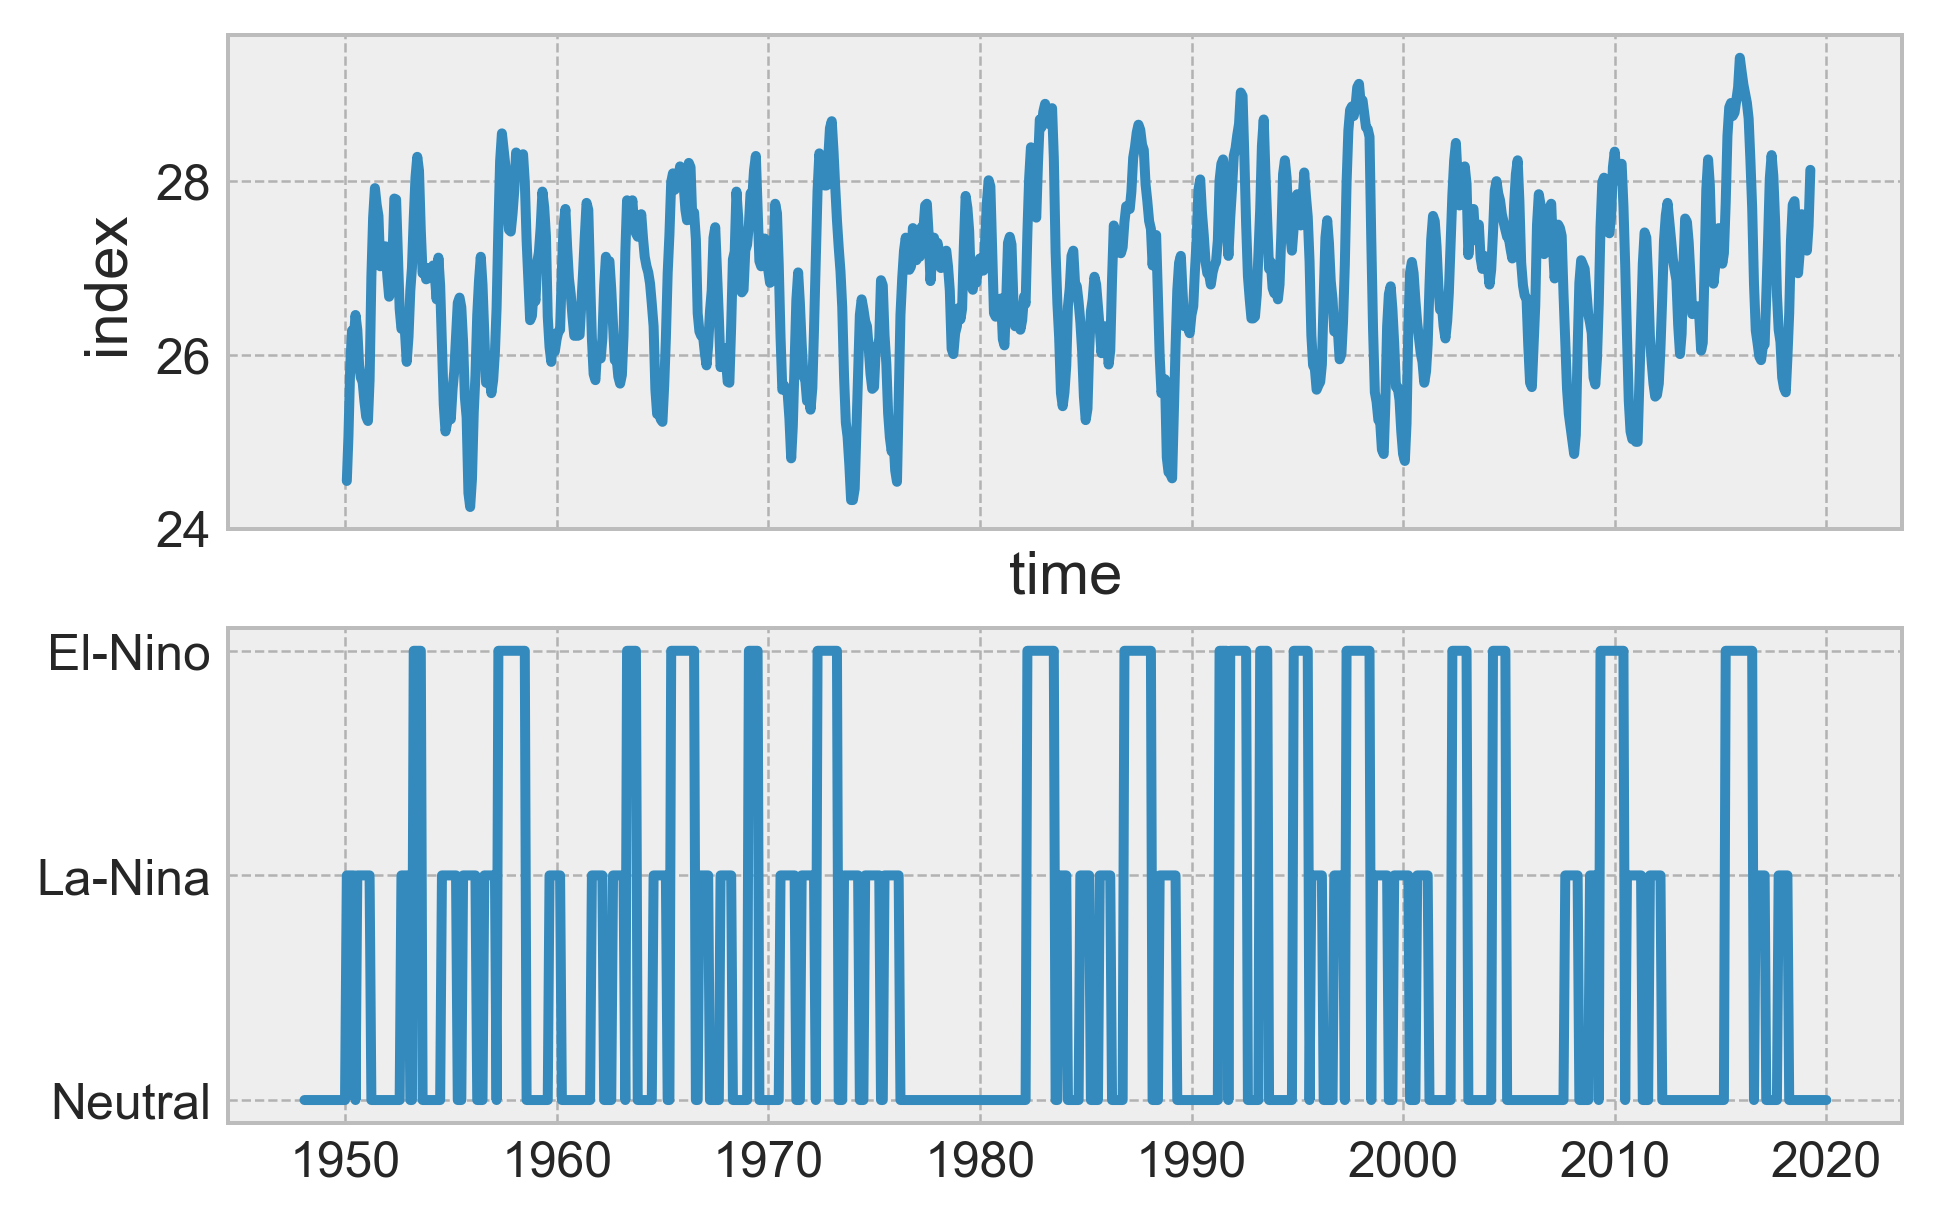

In [184]:
f, ax = plt.subplots(2, 1, sharex=True)
nino34.plot(ax=ax[0])
plt.plot(enso.time, enso)

In [78]:
ds.coords["enso_phase"] = enso.sel(time=ds.TIME, method="nearest")

This is a TS diagram grouped by ENSO phase.

red
black
blue


<ipython-input-185-37833f484136>:18: UserWarning: Legend does not support [<matplotlib.patches.Polygon object at 0x7f75ec600220>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax["t"].get_figure().legend(handles=dist, labels=labels, loc="upper right")
<ipython-input-185-37833f484136>:18: UserWarning: Legend does not support [<matplotlib.patches.Polygon object at 0x7f75ec61aee0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax["t"].get_figure().legend(handles=dist, labels=labels, loc="upper right")
<ipython-input-185-37833f484136>:18: UserWarning: Legend does not support [<matplotlib.patches.Polygon object at 0x7f75ec62d670>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-ar

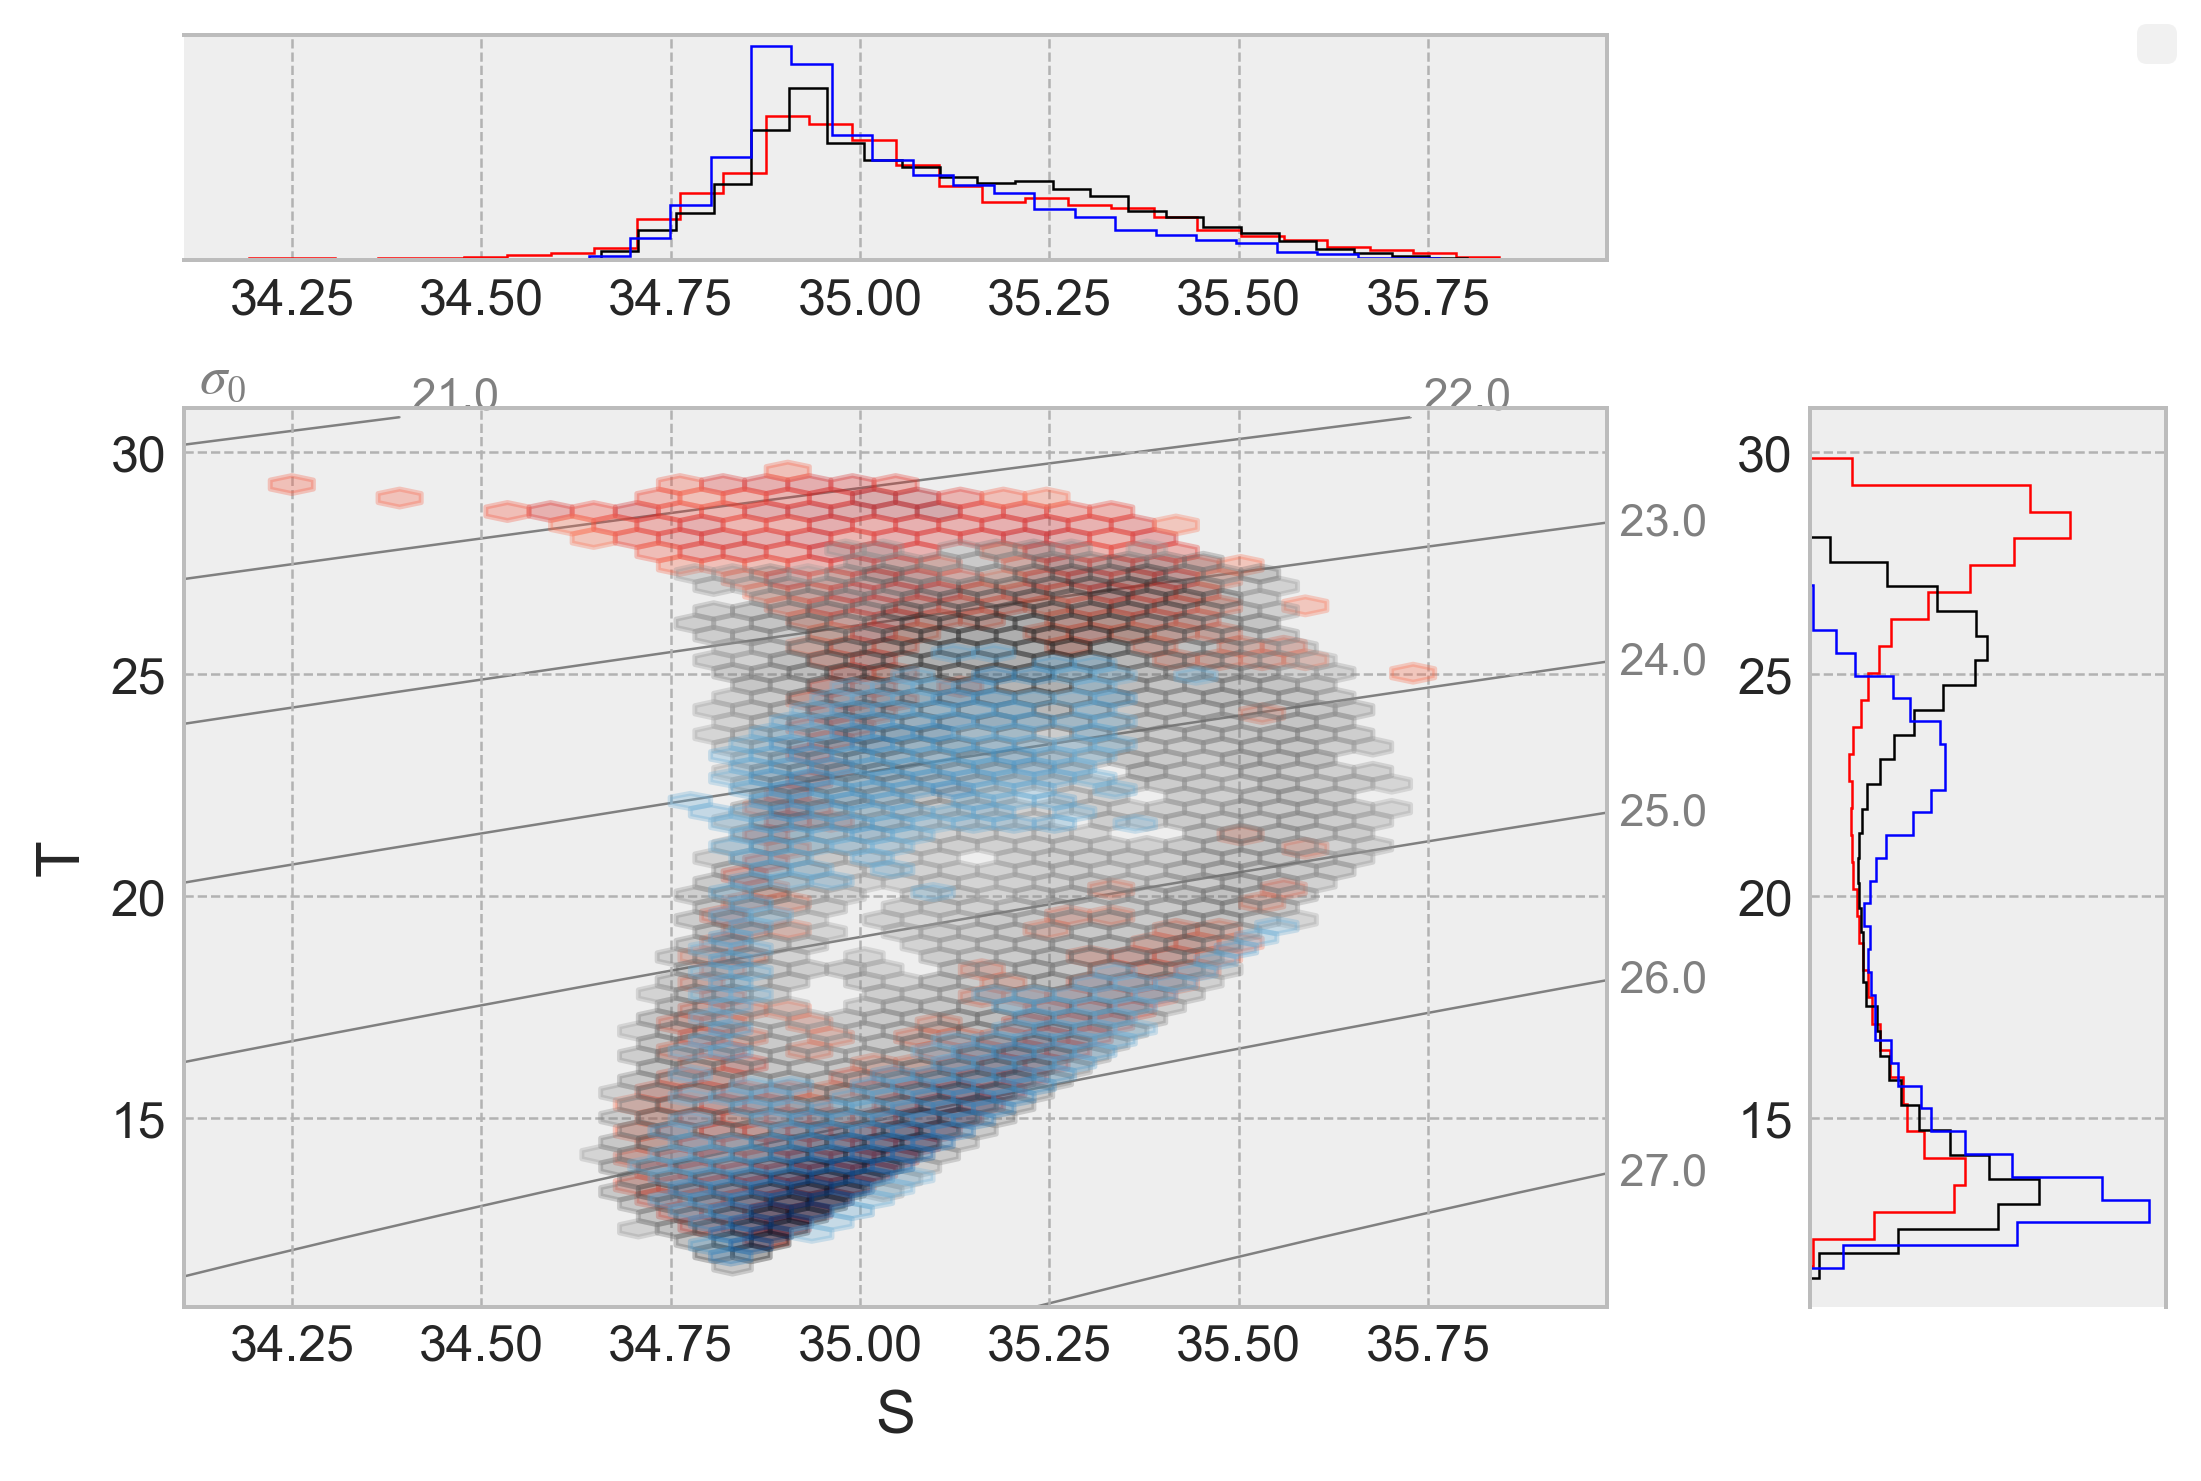

In [185]:
kwargs = dict(hexbin=True, plot_kwargs={"alpha": 0.3, "mincnt": 20, "norm": mpl.colors.LogNorm(1, 500)})
#kwargs = dict(hexbin=False, plot_kwargs={"alpha": 0.1})

ax = None
labels = [ "El-Nino", "Neutral", "La-Nina", ]
dist = []
for phase, cmap, color in zip(labels, [mpl.cm.Reds, mpl.cm.Greys, mpl.cm.Blues], ["red", "black", "blue"]):
    subset = ds.query({"N_POINTS": f"LATITUDE > -2 & LATITUDE < 2 & enso_phase == {phase!r} & PRES > 35 & PRES < 200"})
    kwargs["plot_kwargs"]["cmap"] = cmap
    if ax is not None:
        kwargs.update({"label_spines": False, "rho_levels": None})

    hdl, ax = dcpy.oceans.TSplot(subset.PSAL, subset.TEMP, color=color, **kwargs, ax=ax)
    dist.append(hdl["Thist"][-1])
    

ax["ts"].set_ylim([None, 31])
ax["t"].get_figure().legend(handles=dist, labels=labels, loc="upper right")

## older attempt

I first picked out three years 2008, 2010, 2015-16

In [14]:
ds = xr.open_mfdataset(
    ["argo_140_2008.nc", "argo_140_2010.nc", "argo_140_2016.nc"],
    preprocess=lambda ds: ds.drop_vars("N_POINTS"),
    concat_dim="N_POINTS",
    combine="nested",
)
ds

<xarray.Dataset>
Dimensions:                (N_POINTS: 62174)
Coordinates:
    LATITUDE               (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    LONGITUDE              (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TIME                   (N_POINTS) datetime64[ns] dask.array<chunksize=(8464,), meta=np.ndarray>
Dimensions without coordinates: N_POINTS
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    CYCLE_NUMBER           (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    DATA_MODE              (N_POINTS) object dask.array<chunksize=(8464,), meta=np.ndarray>
    DIRECTION              (N_POINTS) object dask.array<chunksize=(8464,), meta=np.ndarray>
    PLATFORM_NUMBER        (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    POSITION_QC            (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    ...                     ...
    PRES_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    PSAL                   (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    PSAL_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TEMP                   (N_POINTS) float64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TEMP_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
    TIME_QC                (N_POINTS) int64 dask.array<chunksize=(8464,), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           deepak
    Fetched_date:         2021/04/02
    Fetched_constraints:  [x=-145.00/-135.00; y=-1.00/1.00; z=0.0/500.0; t=20...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [15]:
ds.TIME.dt.year.compute()

<xarray.DataArray 'year' (N_POINTS: 62174)>
array([2008, 2008, 2008, ..., 2016, 2016, 2016])
Coordinates:
    LATITUDE   (N_POINTS) float64 0.707 0.707 0.707 ... -0.202 -0.202 -0.202
    LONGITUDE  (N_POINTS) float64 -136.5 -136.5 -136.5 ... -135.6 -135.6 -135.6
    TIME       (N_POINTS) datetime64[ns] 2008-05-01T16:43:14 ... 2016-04-29T0...
Dimensions without coordinates: N_POINTS

In [18]:
ds.coords["year"] = ds.TIME.dt.year

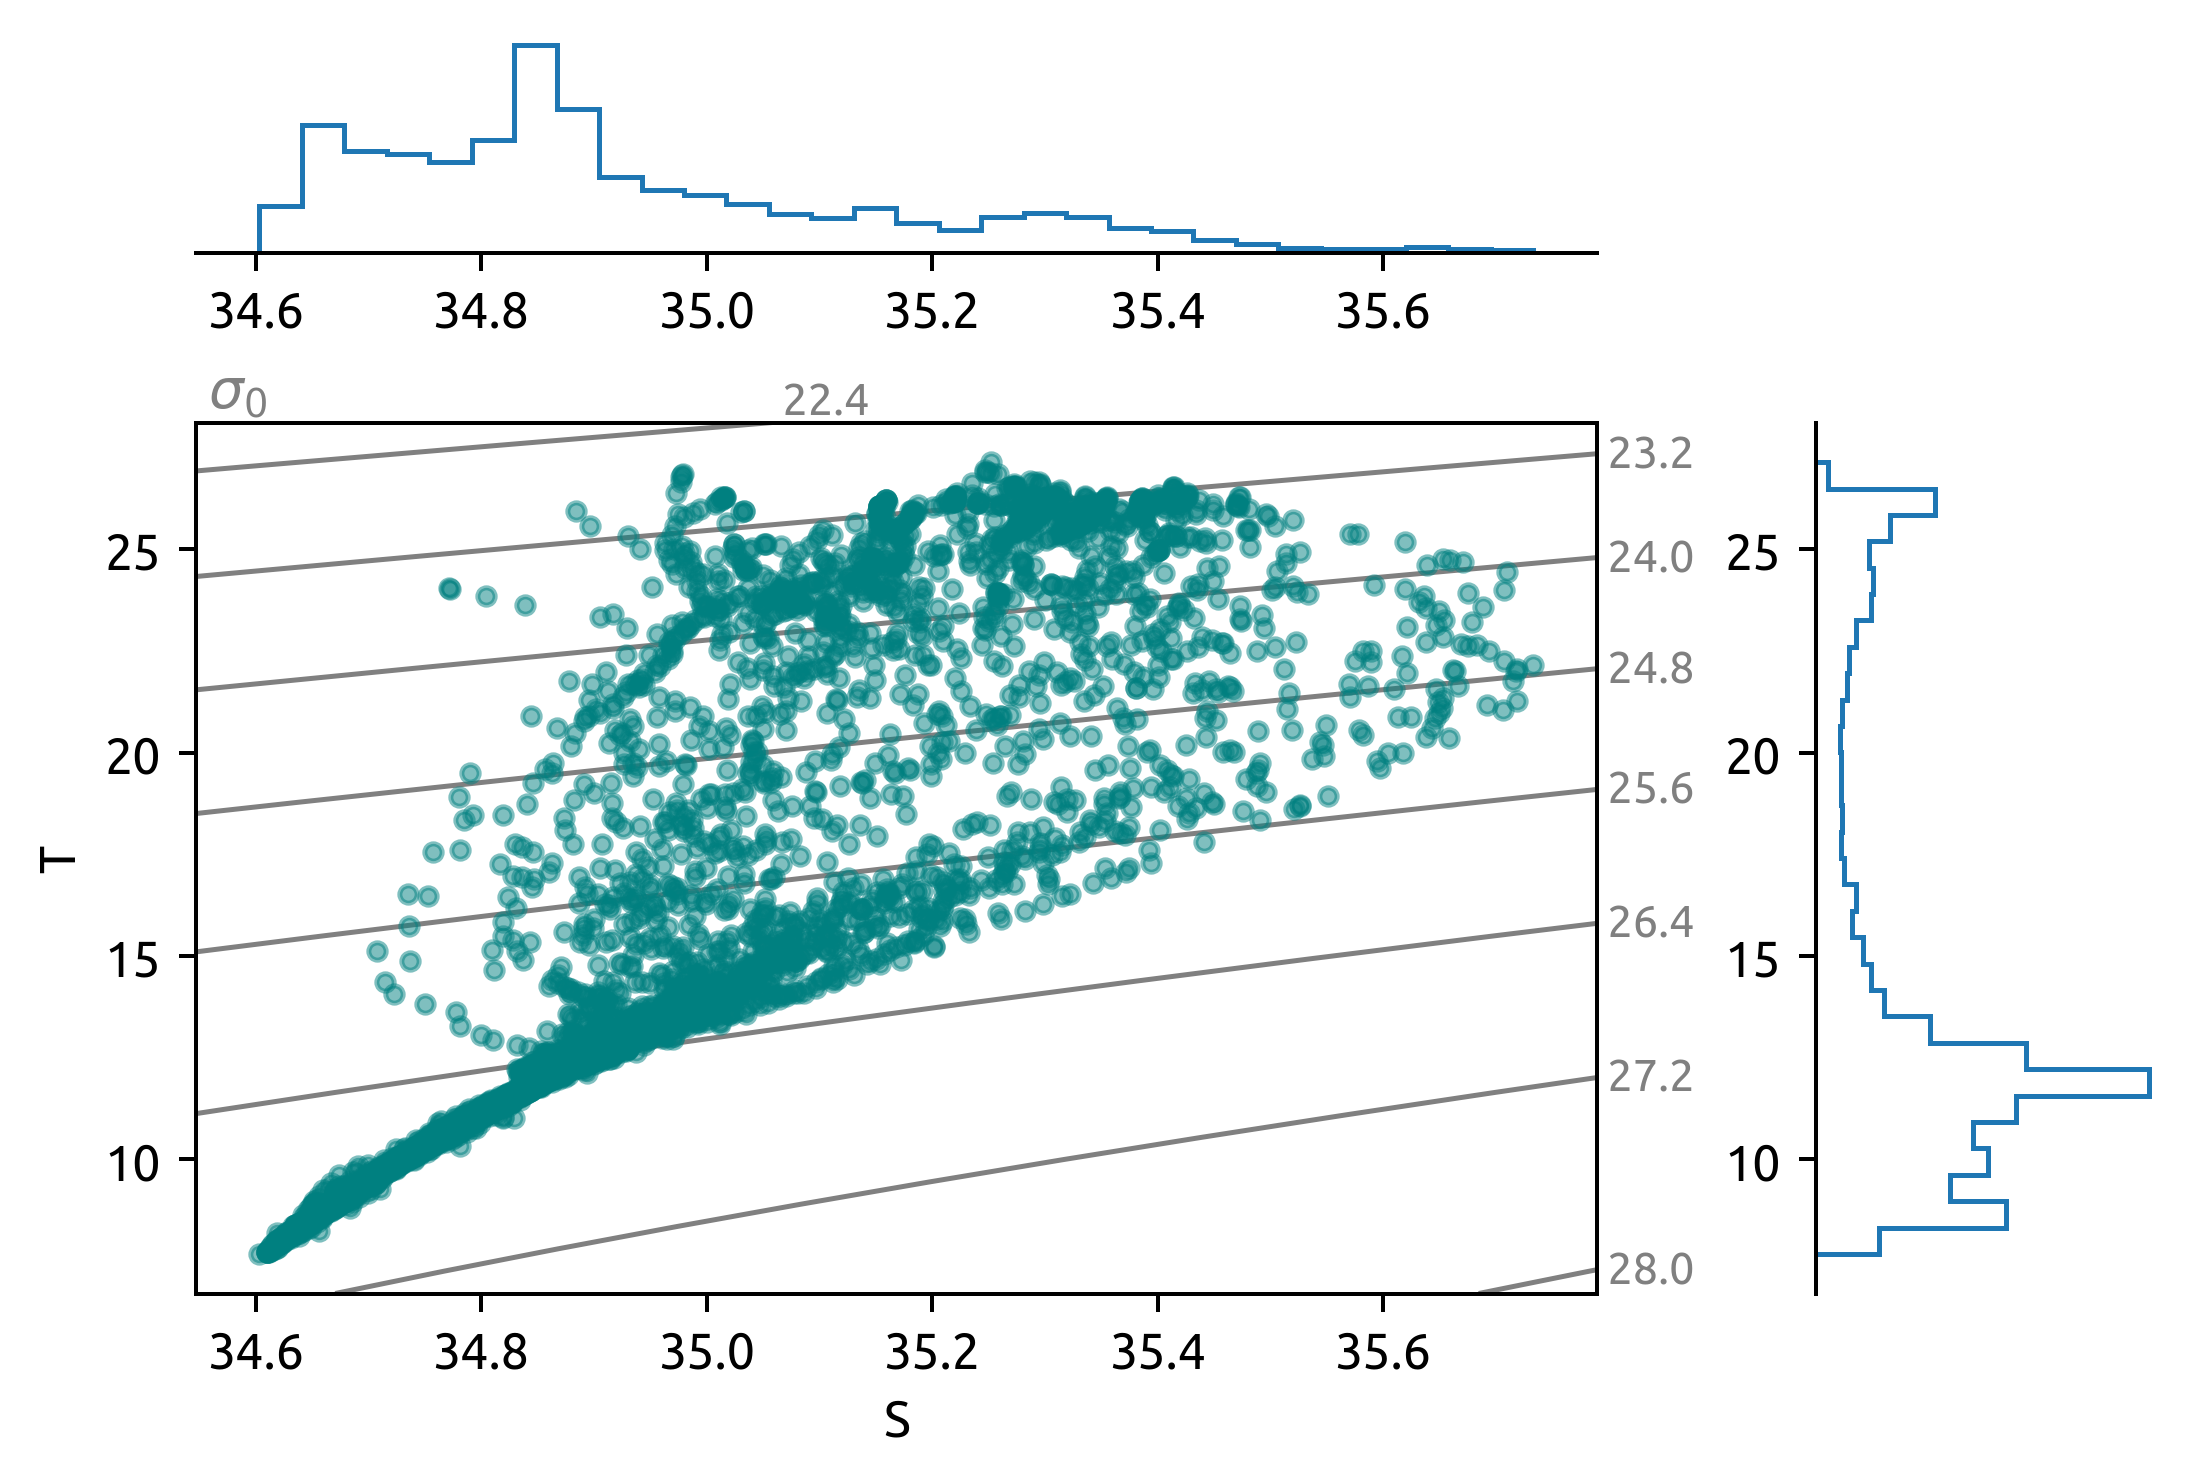

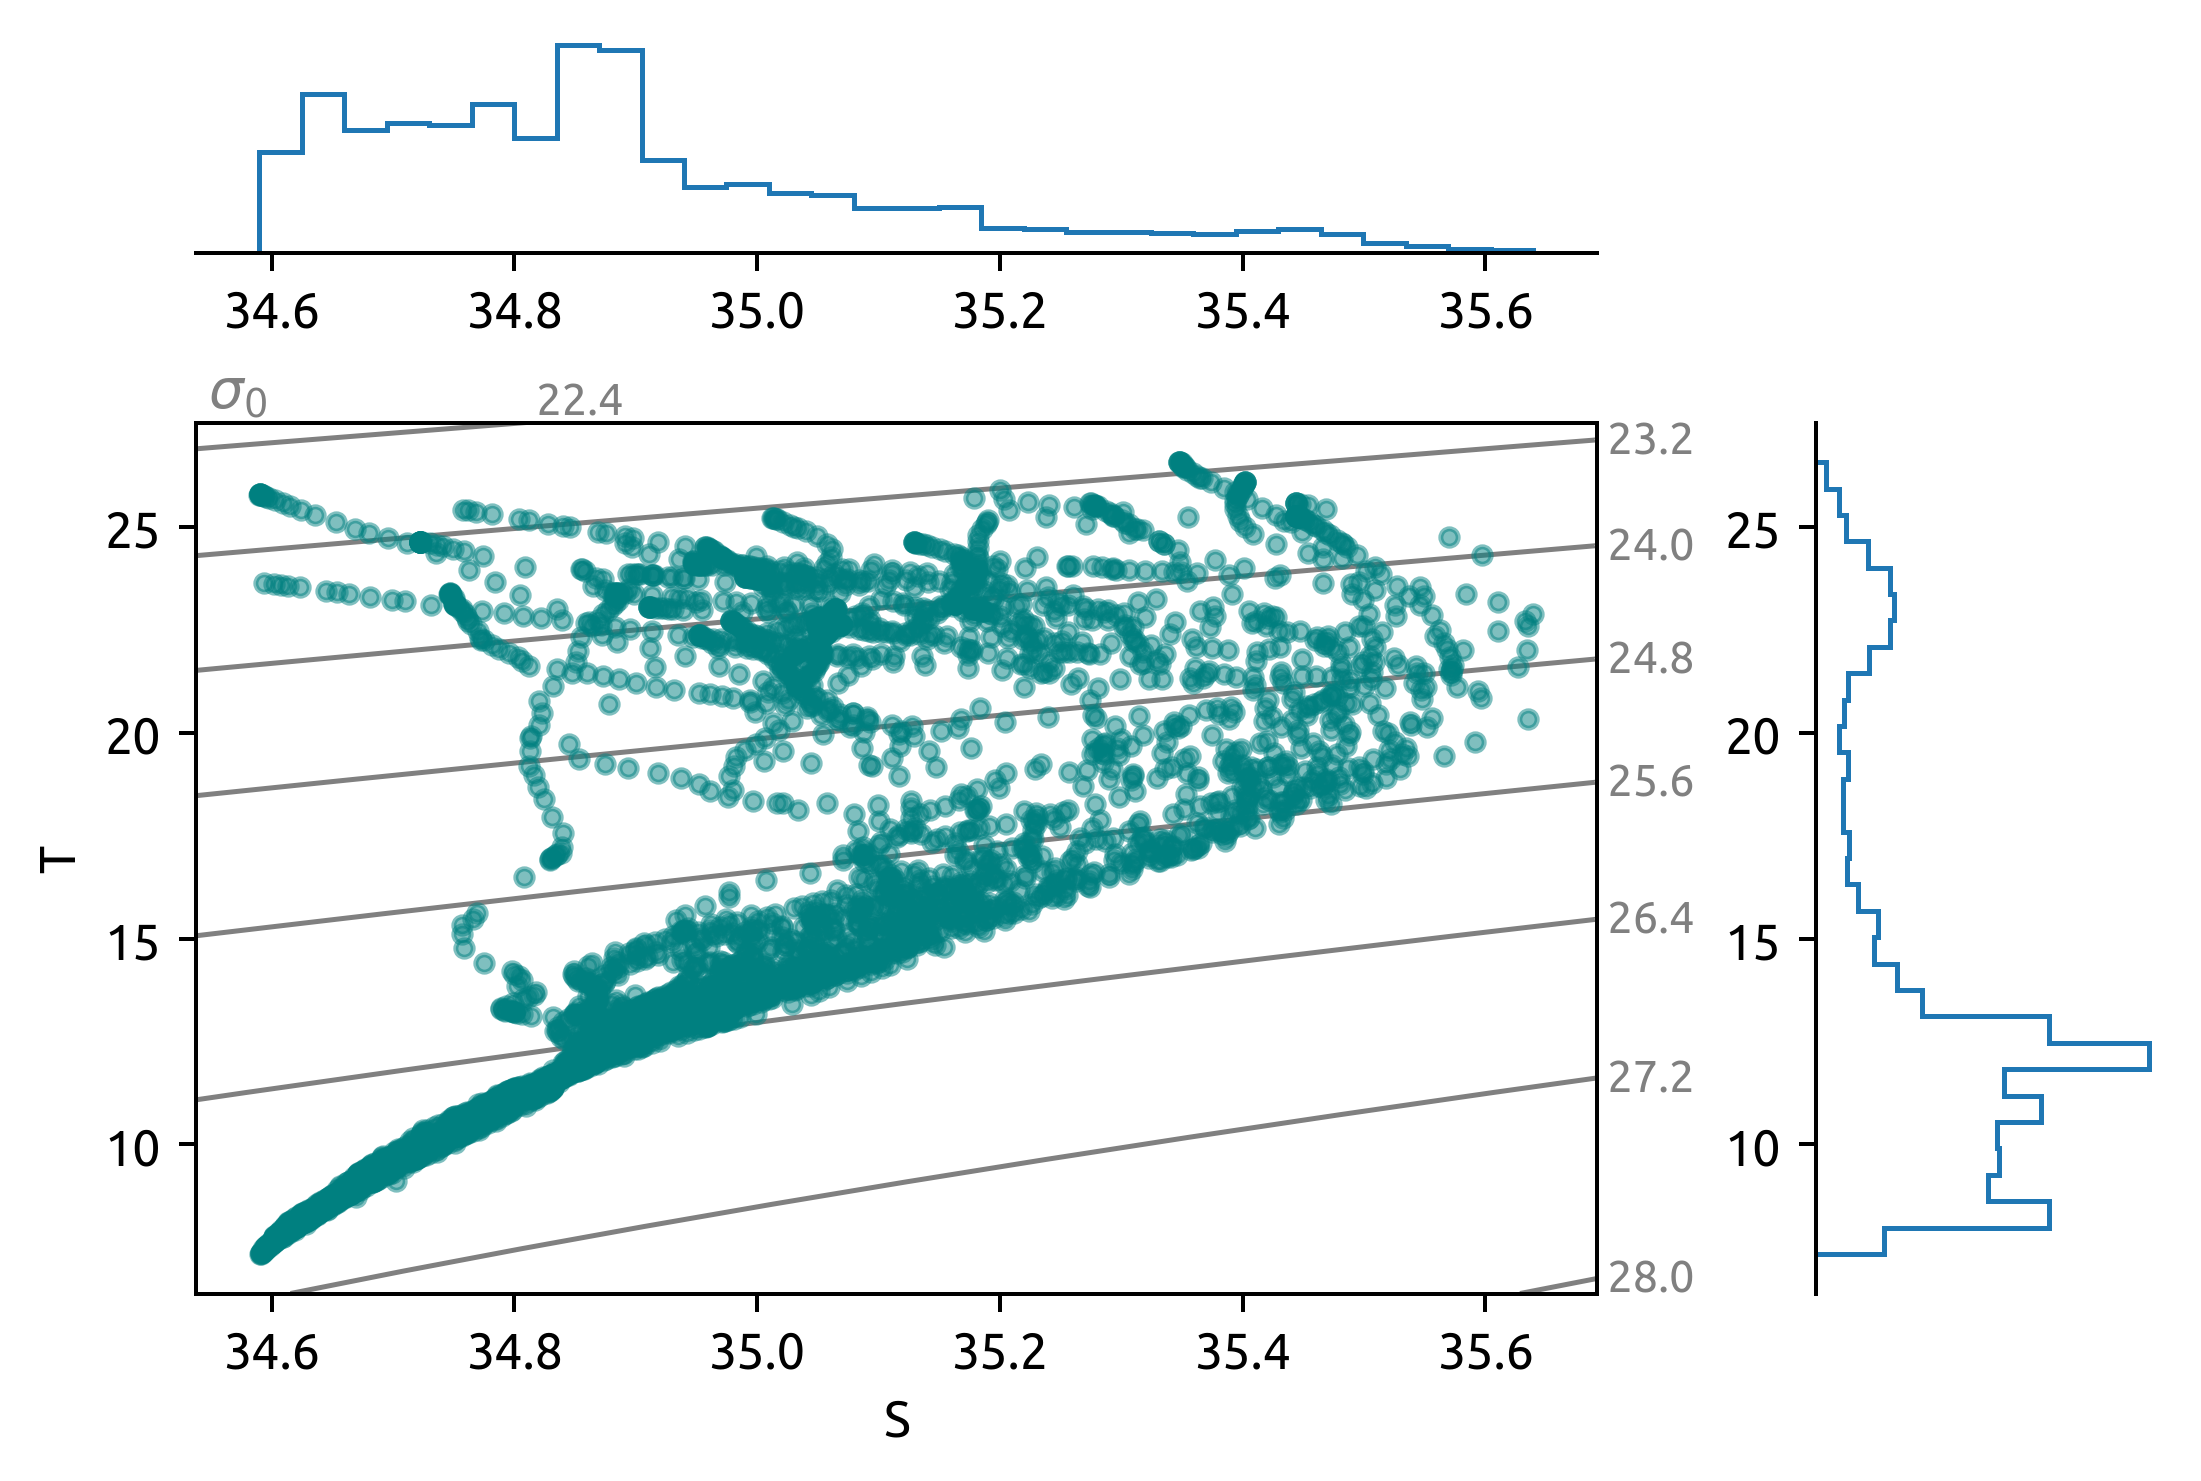

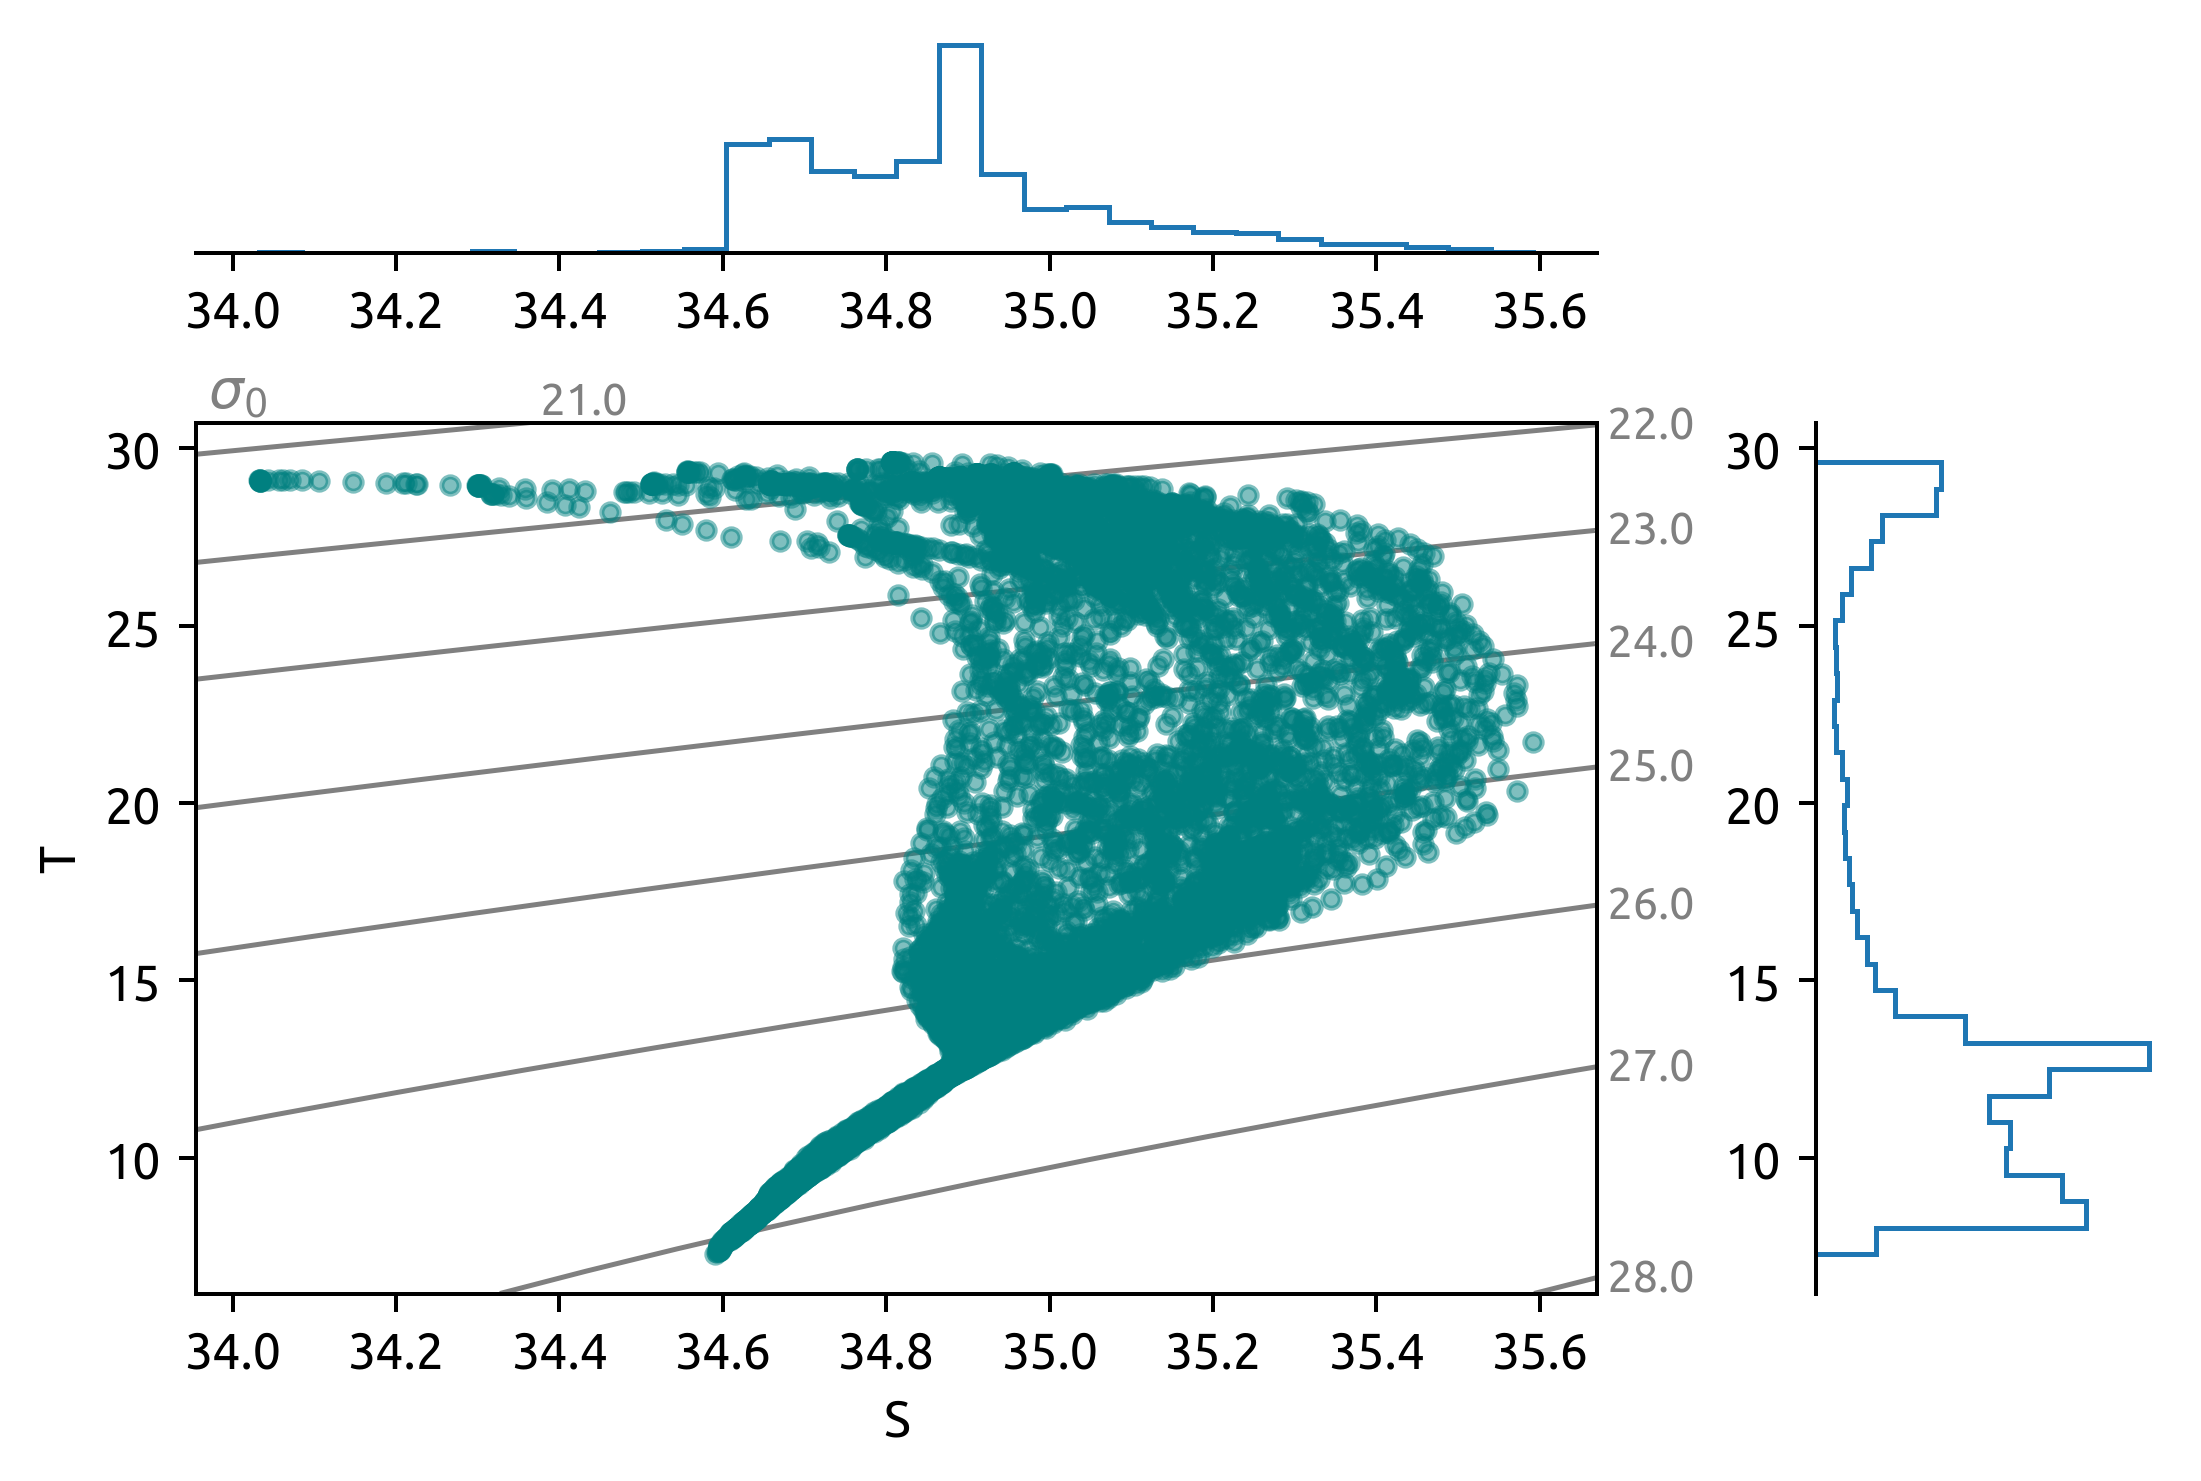

In [28]:
sub = ds.query({"N_POINTS": "year == 2008"})
dcpy.oceans.TSplot(sub.PSAL, sub.TEMP, hexbin=False);

sub = ds.query({"N_POINTS": "year == 2010"})
dcpy.oceans.TSplot(sub.PSAL, sub.TEMP, hexbin=False);


sub = ds.query({"N_POINTS": "year == 2016"})
dcpy.oceans.TSplot(sub.PSAL, sub.TEMP, hexbin=False);

## Download Argo data

In [3]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

In [ ]:
ds = argo_loader.region([-145, -135, -2, 8, 0, 500, "2005-01", "2010-12-31"]).to_xarray()
ds.to_netcdf("argo_140_2005_2010.nc")

In [7]:
ds = argo_loader.region([-145, -135, -2, 8, 0, 500, "2011-01", "2015-12-31"]).to_xarray()

In [8]:
ds.to_netcdf("argo_140_2011_2015.nc")

In [8]:
# Too much data end up getting HTTP 413: Payload too large errors.
for year in range(2016, 2021):
    ds = argo_loader.region([-145, -135, -2, 8, 0, 500, f"{year}-01-01", f"{year}-12-31"]).to_xarray()
    ds.to_netcdf(f"argo_140_{year}_{year}.nc")

---
## TAO


**Conclusion** There is not enough data. Basically no salinity observations off the equator.

In [3]:
import pump

In [13]:
temp = (
    xr.open_dataset("/home/deepak/TaoTritonPirataRama/TAO_TRITON/t_xyzt_dy.cdf")
    .rename({"T_20": "temp"})
    .cf.guess_coord_axis()
    .sel(lon=220)
)

In [11]:
salt = (
    xr.open_dataset("/home/deepak/TaoTritonPirataRama/TAO_TRITON/s_xyzt_dy.cdf")
    .rename({"S_41": "salt"})
    .cf.guess_coord_axis()
    .sel(lon=220)
)

In [66]:
tao = xr.merge([temp, salt], join="inner").sel(lat=[-5, -2, 0, 2, 5])
tao = tao.where(tao < 1000)

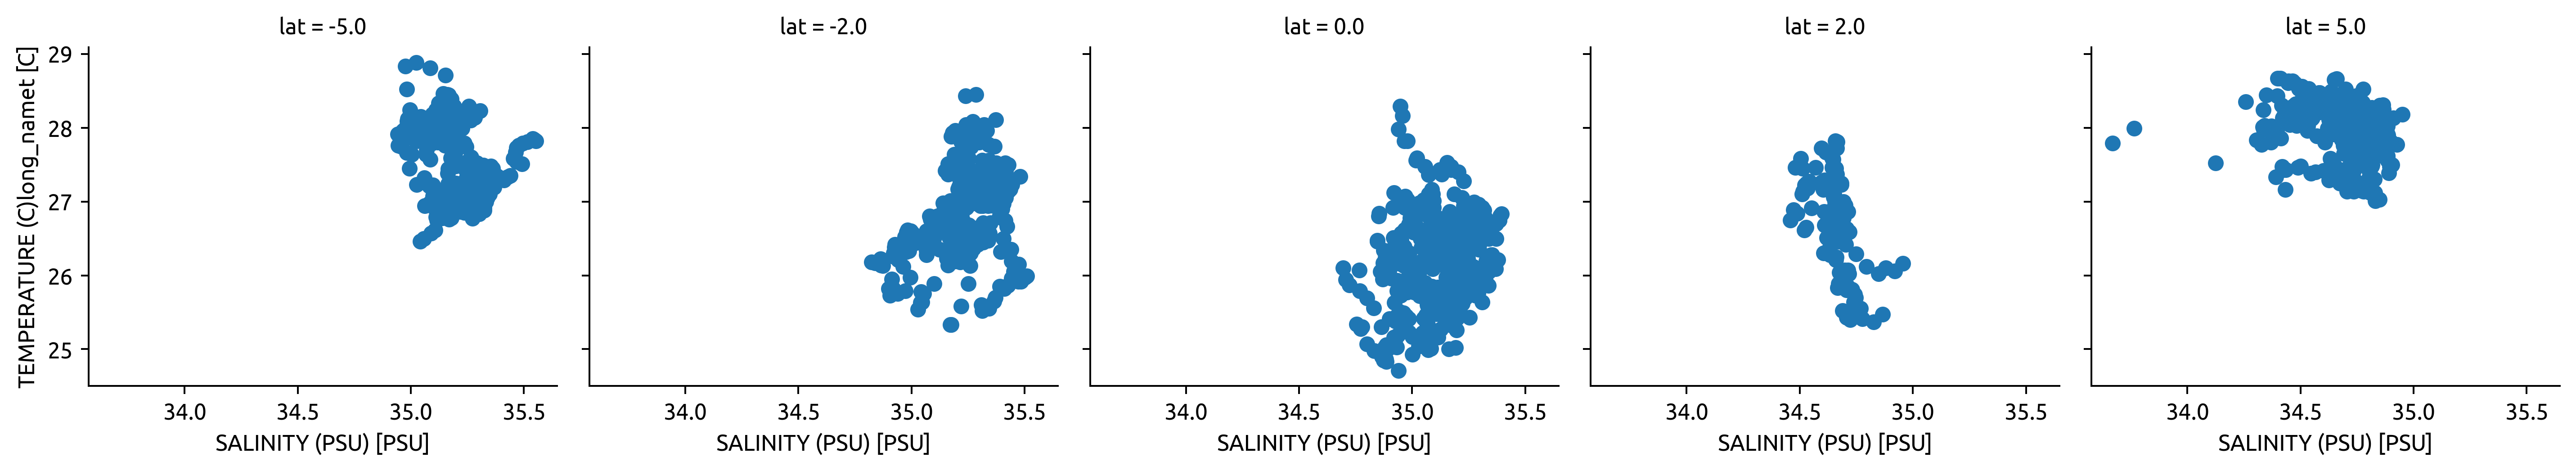

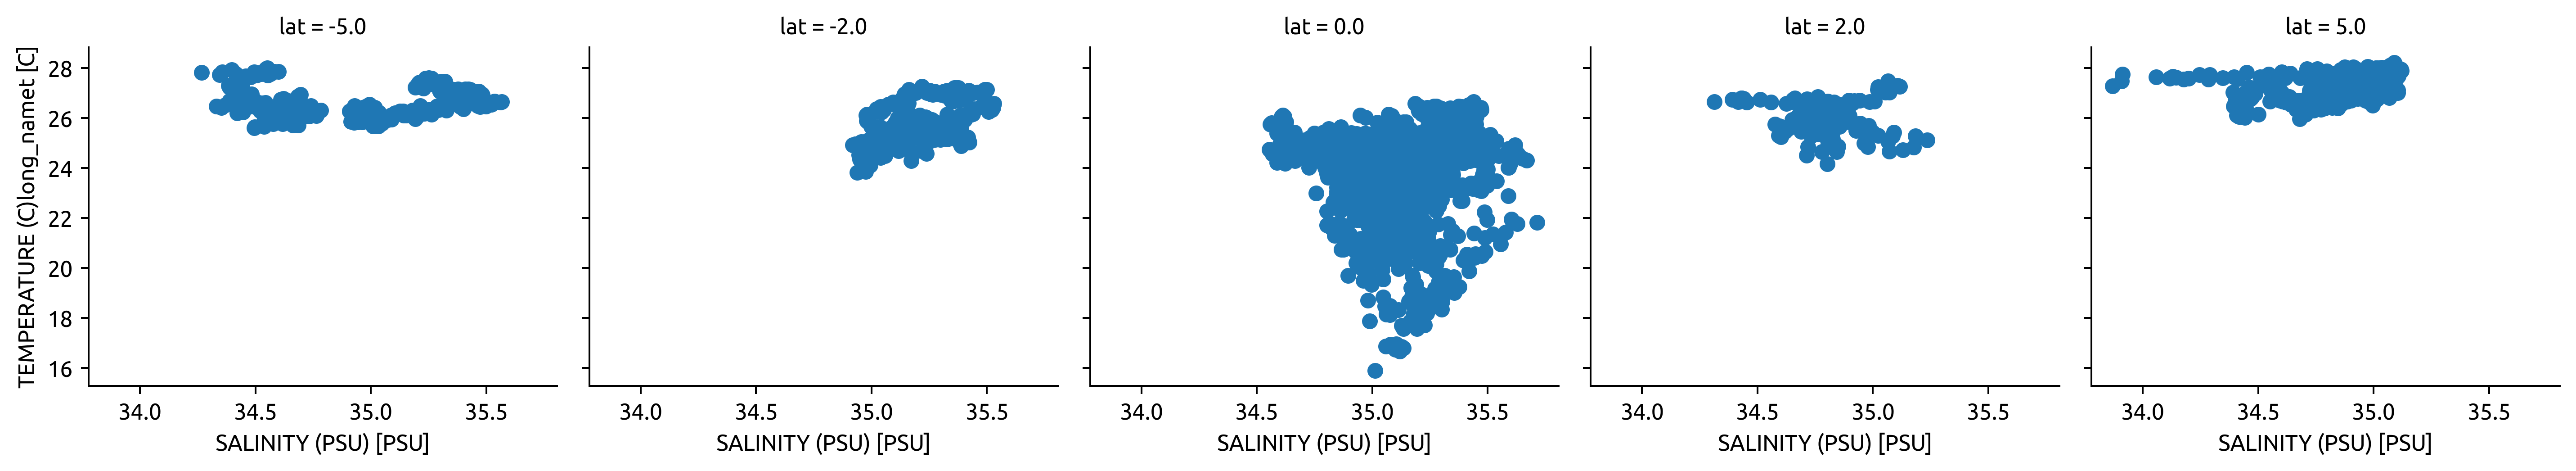

In [58]:
tao.sel(time="2003").plot.scatter("salt", "temp", col="lat")
tao.sel(time=slice("2008-Jun", "2009-Mar")).plot.scatter("salt", "temp", col="lat")